In [65]:
import requests
import pandas as pd
import numpy as np
import warnings
import time
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from skimage.color import rgb2gray
from sklearn.feature_selection import VarianceThreshold
from skimage.exposure import equalize_adapthist, equalize_hist
import skimage.filters as skfilters

In [2]:
sns.set_theme(style='white', palette='pastel', font_scale=1.1)

In [18]:
hnm_file_format = 'data/HnM_{}.parquet'
hnm_img_file = 'images_final/HnM/{}{}'
cna_file_format = 'data/CnA_{}.parquet'
cna_img_file = 'images/CnA_{}{}'

In [4]:
cats = pd.read_parquet(hnm_file_format.format('Categories'))
filters = pd.read_parquet(hnm_file_format.format('Filters'))
items = pd.read_parquet(hnm_file_format.format('Items'))
attributes = pd.read_parquet(hnm_file_format.format('FilterAttributes'))

In [20]:
final_df = pd.read_parquet('data/HnM_Final_Input_Df.parquet')

In [21]:
final_df

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
4,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
5,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
6,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
...,...,...,...,...,...,...,...
22758,0897909012,Weiche Hausschuhe,.jpg,370.0,Kids,Schuhe,Kids_Schuhe
22759,1033466002,Weiche Hausschuhe mit Applikationen,.jpg,370.0,Kids,Schuhe,Kids_Schuhe
22760,0897909013,Weiche Hausschuhe,.jpg,370.0,Kids,Schuhe,Kids_Schuhe
22761,0897909011,Weiche Hausschuhe,.jpg,370.0,Kids,Schuhe,Kids_Schuhe


Getting some images and checking them out

In [22]:
# sampling 10 random images
df = final_df.sample(10)
df

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name
19076,0914448003,Skinny Fit Jeans,.jpg,367.0,Kids,Kleidung,Kids_Kleidung
606,1066903001,Shirt aus Baumwolljersey,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
12348,0673281041,Cardigan mit Reißverschluss,.jpg,227.0,Men,Cardigans & Pullover,Men_Cardigans-&-Pullover
7103,0990400001,Ballerinas aus Veloursleder,.jpg,13.0,Women,Schuhe,Women_Schuhe
22281,1041278001,Baumwollmütze in Rippenstrick,.jpg,369.0,Kids,Accessoires,Kids_Accessoires
3382,1028142003,Trainingshose,.jpg,7.0,Women,Hosen,Women_Hosen
3139,1050589001,H&M+ Nylonjacke mit Colourblocking,.jpg,6.0,Women,Jacken & Mäntel,Women_Jacken-&-Mäntel
4653,0941666009,Slim Mom High Ankle Jeans,.jpg,8.0,Women,Jeans,Women_Jeans
14128,0970245001,Hüfttasche,.jpg,239.0,Men,Accessoires,Men_Accessoires
18611,0981814006,2-teiliges Set mit Print,.jpg,367.0,Kids,Kleidung,Kids_Kleidung


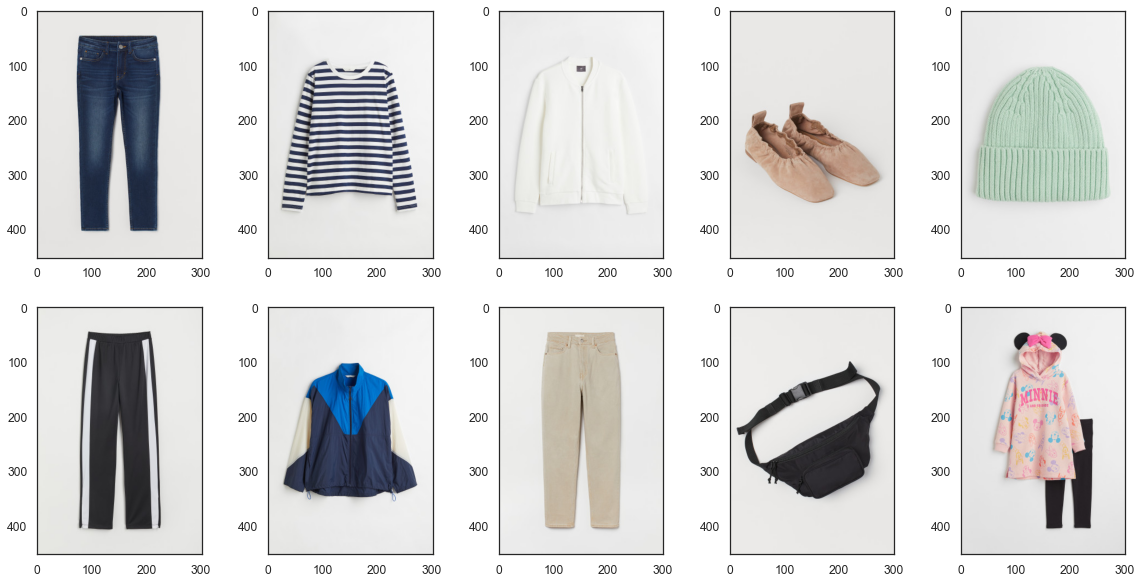

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()

for i in range(len(df)):
    img = plt.imread(hnm_img_file.format(df.iloc[i]['Code'], df.iloc[i]['Img_Ext']))
    axes[i].imshow(img)


### Plotting histograms

In [67]:
def plot_image_distributions(img, ax = None):
    '''Function plots histograms of the three color channels of the image along 
    with the cumulative distributions'''
    if ax is None:
        fig, ax = plt.subplots(1,4, figsize=(20, 5))
        ax = ax.flatten()
    titles=['Red','Green','Blue']
    for i in range(3):
        ax[i].hist(img[:,:,i].flatten(), bins=50, density=True, color=titles[i], alpha=0.3)
        ax[i].set_title(titles[i])
#         ax[i].set_xlabel('Pixel value')
#         ax[i].set_ylabel('Density')
        ax[3].hist(img[:,:,i].flatten(), bins=50, density=True, cumulative=True, color=titles[i], histtype='step')
    ax[3].set_title('Cumulative distributions')  
#     ax[3].set_xlabel('Pixel value')
#     ax[3].set_ylabel('Cumulative density')

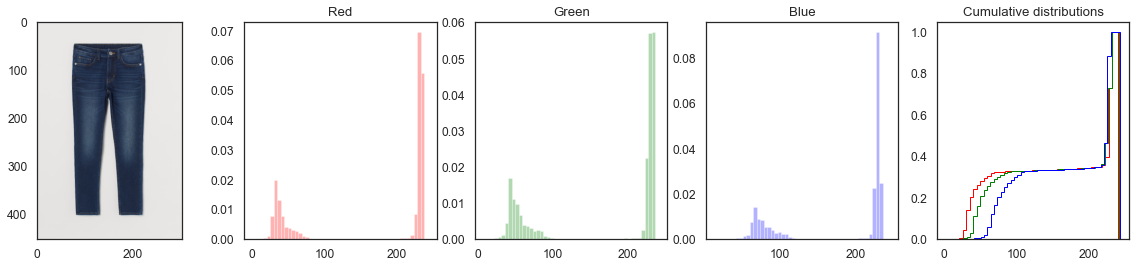

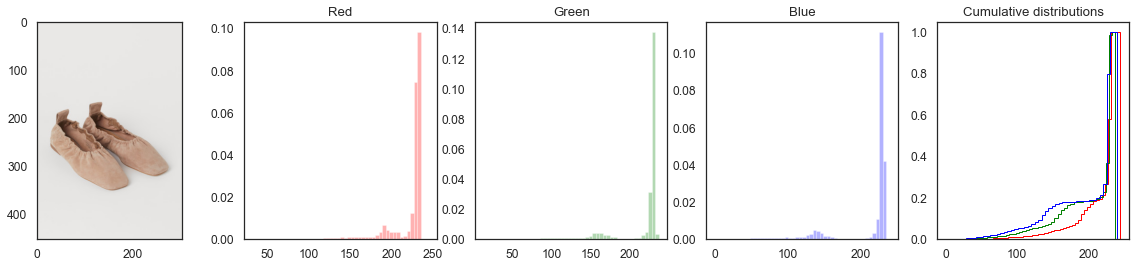

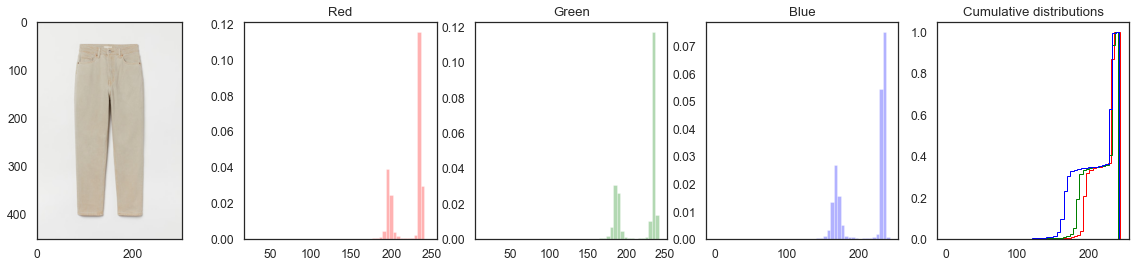

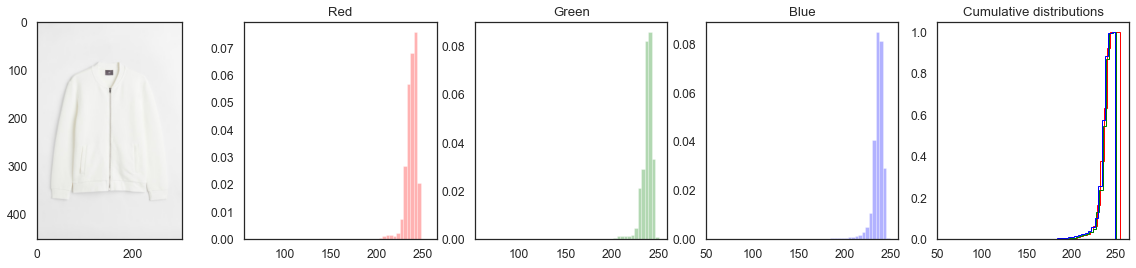

In [40]:
df_4 = df.sample(4)

for i in range(4):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.ravel()
    img = plt.imread(hnm_img_file.format(df_4.iloc[i]['Code'], df_4.iloc[i]['Img_Ext']))
    axes[0].imshow(img)
    plot_image_distributions(img, axes[1:])


### Comparing histograms of equalized images

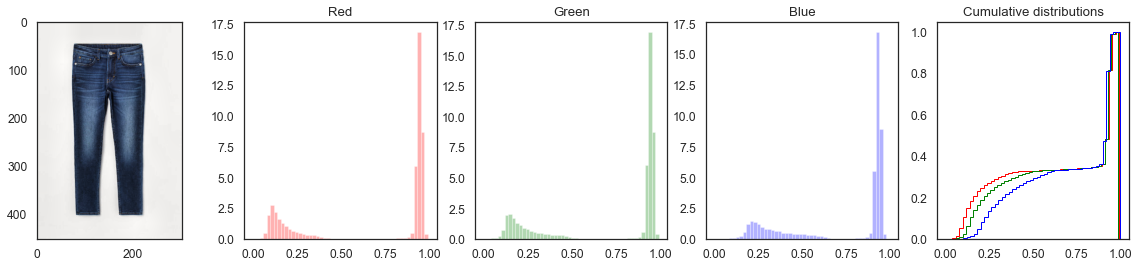

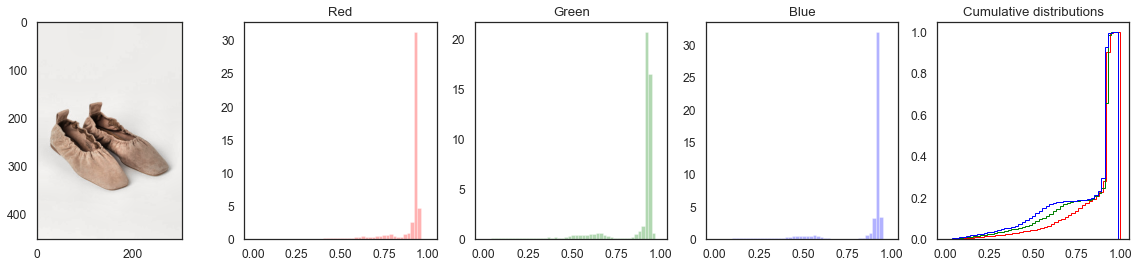

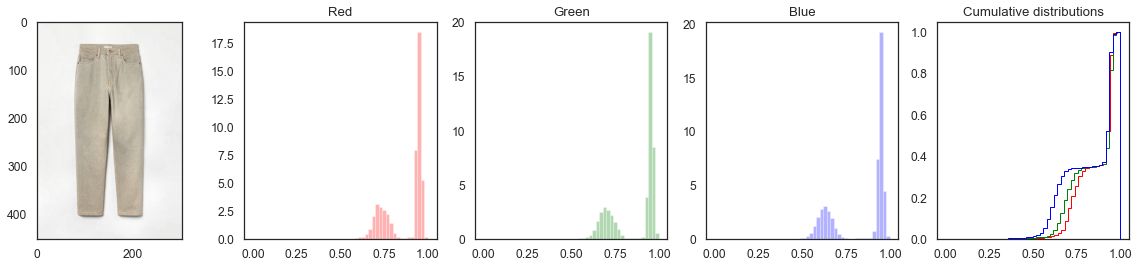

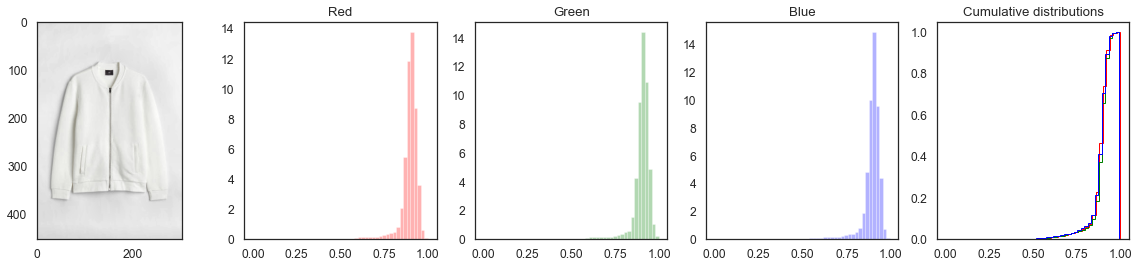

In [69]:

for i in range(4):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.ravel()
    img = plt.imread(hnm_img_file.format(df_4.iloc[i]['Code'], df_4.iloc[i]['Img_Ext']))
    img = equalize_adapthist(img)
    axes[0].imshow(img)
    plot_image_distributions(img, axes[1:])

## Trying out difference of Gaussians

D:\miniconda3\envs\cs25\lib\site-packages\skimage\_shared\utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


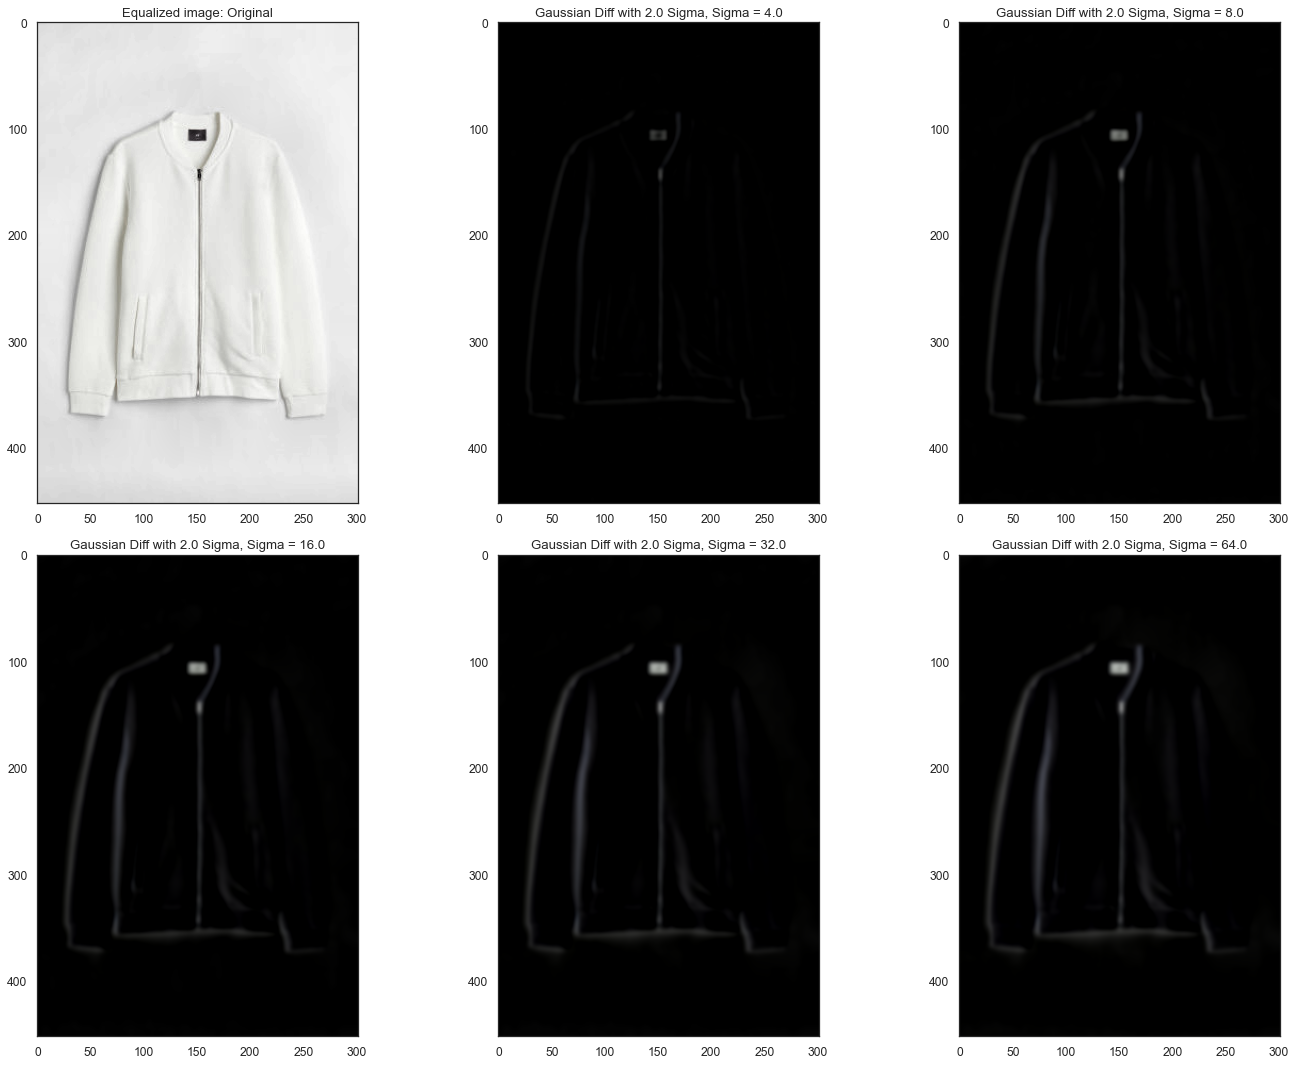

In [63]:
sigma1 = [4.0, 8.0, 16.0, 32.0, 64.0]
sigma2 = 2.0
##  Your code goes here  
fig, axes = plt.subplots(2, 3, figsize = (20, 15))
axes = axes.ravel()

axes[0].imshow(img)
axes[0].set_title('Equalized image: Original')

for i, sigma in enumerate(sigma1):
    img1 = skfilters.gaussian(img, sigma=sigma)
    img2 = skfilters.gaussian(img, sigma=sigma2)
    final_img = img1 - img2
    axes[i+1].imshow(final_img)
    axes[i+1].set_title(f'Gaussian Diff with {sigma2} Sigma, Sigma = {sigma}')

plt.tight_layout()
plt.show()

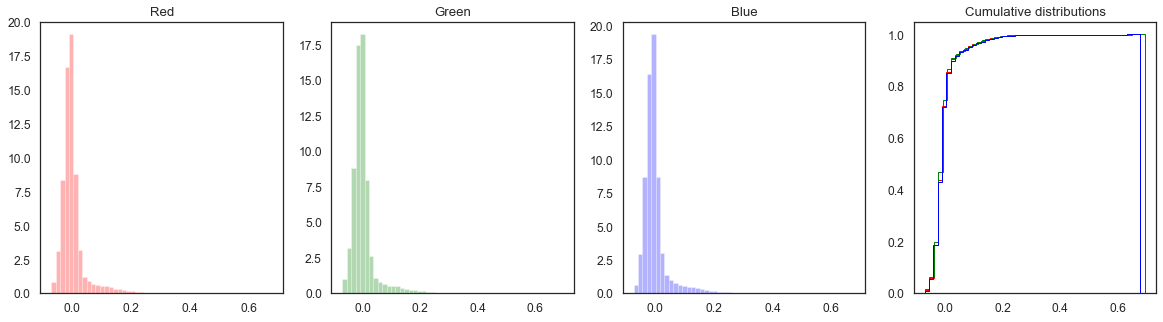

In [64]:
plot_image_distributions(final_img)